/tmp/ipython-input-2325808846.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  india_cases.index = pd.to_datetime(india_cases.index)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting par

Best order: (0, 0, 0) Best seasonal: (0, 2, 0, 12)
MAE: 251744172.75 RMSE: 453455822.5376921


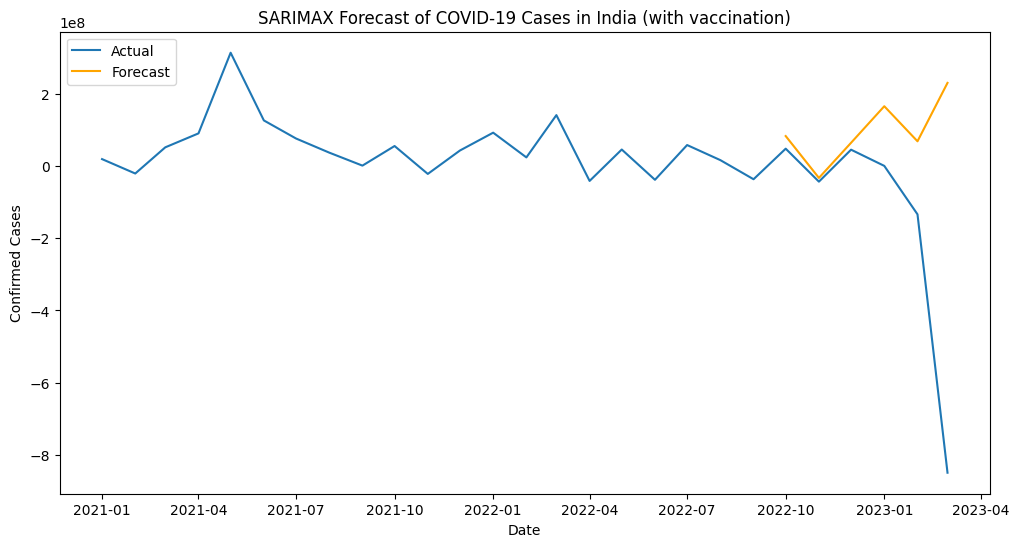

Predicted Outbreak (1=Yes, 0=No):
 2022-10-01    1
2022-11-01    0
2022-12-01    1
2023-01-01    1
2023-02-01    1
2023-03-01    1
Freq: MS, Name: predicted_mean, dtype: int64


In [2]:
# ---------------------------
# STEP 0: Install dependencies
# ---------------------------
!pip install statsmodels
!pip install matplotlib seaborn
!pip install pandas
!pip install numpy

# ---------------------------
# STEP 1: Load datasets
# ---------------------------
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

# JHU COVID-19 cases (GitHub source)
cases_df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
    "csse_covid_19_data/csse_covid_19_time_series/"
    "time_series_covid19_confirmed_global.csv"
)

# Filter India
india_cases = cases_df[cases_df["Country/Region"] == "India"].drop(
    columns=["Province/State","Country/Region","Lat","Long"]
).T
india_cases.columns = ["Confirmed"]
india_cases.index = pd.to_datetime(india_cases.index)

# Convert daily cumulative → monthly new cases
monthly_cases = india_cases.resample("MS").sum().diff().dropna()


# OWID Vaccination dataset (CSV source)
vacc_df = pd.read_csv(
    "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
)
vacc_india = vacc_df[vacc_df["location"] == "India"][["date","people_vaccinated_per_hundred"]]
vacc_india["date"] = pd.to_datetime(vacc_india["date"])
vacc_india = vacc_india.set_index("date").resample("MS").mean()

# Merge cases + vaccination
df = monthly_cases.merge(vacc_india, left_index=True, right_index=True, how="inner")
df = df.dropna()

cases = df["Confirmed"]
exog = df[["people_vaccinated_per_hundred"]]

# ---------------------------
# STEP 2: Train-test split
# ---------------------------
n_test = 6
train, test = cases[:-n_test], cases[-n_test:]
exog_train, exog_test = exog[:-n_test], exog[-n_test:]

# ---------------------------
# STEP 3: Manual Grid Search for SARIMAX Parameters
# ---------------------------
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # monthly seasonality

best_aic = float("inf")
best_order = None
best_seasonal = None
best_model = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train, exog=exog_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = results
        except:
            continue

print("Best order:", best_order, "Best seasonal:", best_seasonal)

# ---------------------------
# STEP 4: Forecast
# ---------------------------
pred = best_model.get_forecast(steps=n_test, exog=exog_test)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Evaluate
mae = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print("MAE:", mae, "RMSE:", rmse)

# ---------------------------
# STEP 5: Plot results
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(cases.index, cases, label="Actual")
plt.plot(pred_mean.index, pred_mean, label="Forecast", color="orange")
plt.fill_between(pred_mean.index,
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1],
                 color="pink", alpha=0.3)
plt.title("SARIMAX Forecast of COVID-19 Cases in India (with vaccination)")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

# ---------------------------
# STEP 6: Optional: Convert to Outbreak Prediction
# ---------------------------
threshold = 50000  # example: outbreak if monthly cases > 50k
pred_outbreak = (pred_mean > threshold).astype(int)
print("Predicted Outbreak (1=Yes, 0=No):\n", pred_outbreak)
